# BiteMe | Preprocessing

The purpose of this notebook is to create the image preprocessing pipeline to be used during train/test time. The output will be functions we can include in the `preprocessing.py` script. Parts of this notebook explore how best to optimise image preprocessing not only for performance, but for a testing environment. Functions therefore created enable iterative, logged and reproducible image preprocessing (predominantly for image augmentations). 

TODO: 
 - [Histogram Equalization and Adaptive Histogram Equalization (CLAHE)](https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/)
 - GANs
 - Image centring / normalisation

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json

from tqdm import tqdm

import cv2
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

sys.path.append("..")
from helpers import read_images, get_train_test_split, get_augs
from constants import ROWS, COLS, CHANNELS, SEED, TEST_SIZE, VERBOSE

np.random.seed(SEED)
ia.seed(SEED)

In [2]:
# Define directories
base_dir_path = "../"

data_dir_path = os.path.join(base_dir_path, "data")
data_cleaned_dir_path = os.path.join(data_dir_path, "cleaned")
data_preprocessed_dir_path = os.path.join(data_dir_path, "preprocessed")

data_dir = os.listdir(data_dir_path)
data_cleaned_dir = os.listdir(data_cleaned_dir_path)

metadata_cleaned_path = os.path.join(data_cleaned_dir_path, "metadata.csv")
metadata = pd.read_csv(metadata_cleaned_path)

# Write processed images to disk
write_preprocessed_images = False

metadata.head()

,img_name,img_path,label
0,7059b14d2aa03ed6c4de11afa32591995181d31c.jpg,../data/cleaned/none/7059b14d2aa03ed6c4de11afa...,none
1,ea1b100b581fcdb7ddfae52cc62347a99e304ba4.jpg,../data/cleaned/none/ea1b100b581fcdb7ddfae52cc...,none
2,1a1442990ff143b7560e5757d9f76d37ab007f48.jpg,../data/cleaned/none/1a1442990ff143b7560e5757d...,none
3,6eac051b9c45ff6821ec8675216f371711b7cea9.jpg,../data/cleaned/none/6eac051b9c45ff6821ec86752...,none
4,fc72767f8520df9b2b83941077dc0ee013eb9399.jpg,../data/cleaned/none/fc72767f8520df9b2b8394107...,none


## Split Data into Train/Test

In [3]:
# Split data into train and test
train_idx, test_idx, y_train, y_test = get_train_test_split(
    metadata_df=metadata, 
    test_size=TEST_SIZE,
    verbose=VERBOSE
)

192 train images
22 test images

TRAIN IMAGE COUNTS
------------------
tick        26
mosquito    25
horsefly    25
bedbug      25
none        25
ant         23
bee         22
mite        21
Name: label, dtype: int64

TEST IMAGE COUNTS
------------------
bedbug      3
tick        3
ant         3
horsefly    3
mosquito    3
none        3
mite        2
bee         2
Name: label, dtype: int64


In [4]:
# Re-write metadata csv for preprocessed
# WILL NEED TO UPDATE IF THERE WE GENERATE SYNTHETIC IMAGES
metadata["split"] = "train"
metadata["split"][test_idx] = "test"

metadata_preprocessed_path = os.path.join(data_preprocessed_dir_path, "metadata.csv")
metadata.to_csv(metadata_preprocessed_path, index=False)

## Create Preprocessing Pipeline

In [5]:
img_array = read_images(
    data_dir_path=data_cleaned_dir_path, 
    rows=ROWS, 
    cols=COLS, 
    channels=CHANNELS, 
    write_images=False, 
    output_data_dir_path=None,
    verbose=VERBOSE
)

# Split images into train/test
X_train = img_array[train_idx]
X_test = img_array[test_idx]    

Reading images from: ../data/cleaned
Rows set to 512
Columns set to 512
Channels set to 3
Writing images is set to: False
Reading images...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.61it/s]


Image reading complete.
Image array shape: (214, 512, 512, 3)


In [6]:
if write_preprocessed_images == True:
    # Make train/test dirs for preprocessed images
    if "train" not in os.listdir(data_preprocessed_dir_path):
        os.mkdir(os.path.join(data_preprocessed_dir_path, "train"))
    if "test" not in os.listdir(data_preprocessed_dir_path):
        os.mkdir(os.path.join(data_preprocessed_dir_path, "test"))


    # Write preprocessed images (split) to preprocessed directory
    for idx in tqdm(metadata.index):
        if metadata["split"][idx] == "train":
            img_dir_path = os.path.join(data_preprocessed_dir_path, "train", metadata["label"][idx])
            # If doesn't exist, create label directory
            if not os.path.isdir(img_dir_path):
                os.mkdir(img_dir_path)
            # Create img write path
            img_path_write = os.path.join(img_dir_path, metadata["img_name"][idx])
            # Write to train img directory
            cv2.imwrite(img_path_write, img_array[idx])
            
        elif metadata["split"][idx] == "test":
            # Write to test directory
            img_dir_path = os.path.join(data_preprocessed_dir_path, "test", metadata["label"][idx])
            # If doesn't exist, create label directory
            if not os.path.isdir(img_dir_path):
                os.mkdir(img_dir_path)
            # Create img write path
            img_path_write = os.path.join(img_dir_path, metadata["img_name"][idx])
            # Write to train img directory
            cv2.imwrite(img_path_write, img_array[idx])

In [7]:
# Create augmentations dictionary and write to json
augs = {
    "Fliplr": {"aug": iaa.Fliplr, "args": {"p": 1.0}}, 
    "Flipud": {"aug": iaa.Flipud,"args": {"p": 1.0}}, 
    "GaussianBlur": {"aug": iaa.GaussianBlur,"args": {"sigma": 6.0}}, 
    "AverageBlur": {"aug": iaa.AverageBlur,"args": {"k": 20.0}}, 
    "MotionBlur": {"aug": iaa.MotionBlur,"args": {"k": 15}}, 
    "MultiplyBrightness": {"aug": iaa.MultiplyBrightness,"args": {"mul": 0.5}}, 
    "MultiplyHue": {"aug": iaa.MultiplyHue,"args": {"mul": 0.8}}, 
    "MultiplySaturation": {"aug": iaa.MultiplySaturation,"args": {"mul": 0.5}}, 
    "Grayscale": {"aug": iaa.Grayscale,"args": {"alpha": 0.7}}, 
    "GammaContrast": {"aug": iaa.GammaContrast,"args": {"gamma": 2.0}}, 
    "SigmoidContrast": {"aug": iaa.SigmoidContrast,"args": {"gain": 9.0}}, 
    "LinearContrast": {"aug": iaa.LinearContrast,"args": {"alpha": 2.0}}, 
    "Affine": {"aug": iaa.Affine,"args": {"scale": 0.8}}, 
    "ScaleX": {"aug": iaa.ScaleX,"args": {"scale": 0.8}}, 
    "ScaleY": {"aug": iaa.ScaleY,"args": {"scale": 0.8}}, 
    "TranslateX": {"aug": iaa.TranslateX,"args": {"percent": 0.1}}, 
    "TranslateY": {"aug": iaa.TranslateY,"args": {"percent": 0.1}}, 
    "Rotate": {"aug": iaa.Rotate,"args": {"rotate": 45.0}}, 
    "ShearX": {"aug": iaa.ShearX,"args": {"shear": 20.0}}, 
    "ShearY": {"aug": iaa.ShearY,"args": {"shear": 20.0}},
    "GaussianNoise": {"aug": iaa.imgcorruptlike.GaussianNoise,"args": {"severity": 5}}, 
    "ShotNoise": {"aug": iaa.imgcorruptlike.ShotNoise,"args": {"severity": 5}}, 
    "ImpulseNoise": { "aug": iaa.imgcorruptlike.ImpulseNoise,"args": {"severity": 5}}, 
    "SpeckleNoise": {"aug": iaa.imgcorruptlike.SpeckleNoise,"args": {"severity": 5}}, 
    "DefocusBlur": {"aug": iaa.imgcorruptlike.DefocusBlur,"args": {"severity": 5}}, 
    "ZoomBlur": {"aug": iaa.imgcorruptlike.ZoomBlur,"args": {"severity": 4}}, 
    "Contrast": {"aug": iaa.imgcorruptlike.Contrast,"args": {"severity": 2}}, 
    "Brightness": {"aug": iaa.imgcorruptlike.Brightness,"args": {"severity": 2}},
    "Saturate": {"aug": iaa.imgcorruptlike.Saturate,"args": {"severity": 2}}, 
    "Solarize": {"aug": iaa.Solarize,"args": {"threshold": 1}}, 
    "EnhanceColor": {"aug": iaa.pillike.EnhanceColor,"args": {"factor": 4.0}}, 
    "EnhanceContrast": {"aug": iaa.pillike.EnhanceContrast,"args": {"factor": 2.0}}, 
    "EnhanceBrightness": {"aug": iaa.pillike.EnhanceBrightness,"args": {"factor": 1.4}}, 
    "EnhanceSharpness": {"aug": iaa.pillike.EnhanceSharpness,"args": {"factor": 10.0}}, 
    "AdditiveGaussianNoise": {"aug": iaa.AdditiveGaussianNoise,"args": {"loc": 50.0}}, 
    "AdditiveLaplaceNoise": {"aug": iaa.AdditiveLaplaceNoise,"args": {"loc": 50.0}}, 
    "AdditivePoissonNoise": {"aug": iaa.AdditivePoissonNoise,"args": {"lam": 20.0}}, 
    "Cutout": {"aug": iaa.Cutout,"args": {"nb_iterations": 1,"size": 0.2,"fill_mode": "gaussian","fill_per_channel": True}}, 
    "Dropout": {"aug": iaa.Dropout,"args": {"p": 0.2,"per_channel": 0.5}}, 
    "CoarseDropout": {"aug": iaa.CoarseDropout,"args": {"size_percent": 0.5}}, 
    "ImpulseNoise": {"aug": iaa.ImpulseNoise,"args": {"p": 0.1}}, 
    "SaltAndPepper": {"aug": iaa.SaltAndPepper,"args": {"p": 0.1}}
}

## Run Preprocessing Pipeline

In [8]:
# Example preprocessing run
X_train_aug, y_train_aug = get_augs(
    imgs_raw=X_train[0:20], 
    labels_raw=y_train[0:20],
    augs=augs,
    keep_originals=True,
    verbose=VERBOSE
)

Fliplr(name=UnnamedFliplr, parameters=[Deterministic(int 1)], deterministic=False)
Flipud(name=UnnamedFlipud, parameters=[Deterministic(int 1)], deterministic=False)
GaussianBlur(name=UnnamedGaussianBlur, parameters=[Deterministic(float 6.00000000)], deterministic=False)
AverageBlur(name=UnnamedAverageBlur, parameters=[Deterministic(int 20)], deterministic=False)
MotionBlur(name=UnnamedMotionBlur, parameters=[<imgaug.augmenters.blur._MotionBlurMatrixGenerator object at 0x7f591ad02440>, function], deterministic=False)
MultiplyAndAddToBrightness(mul=Multiply(name=UnnamedMultiply, parameters=[Deterministic(float 0.50000000), Deterministic(int 0)], deterministic=False), add=Identity(name=UnnamedIdentity, parameters=[], deterministic=False), to_colorspace=Choice(a=['YCrCb', 'HSV', 'HLS', 'Lab', 'Luv', 'YUV'], replace=True, p=None), from_colorspace=RGB, random_order=False, name=UnnamedMultiplyBrightness, deterministic=False)
WithHueAndSaturation(from_colorspace=RGB, name=UnnamedMultiplyHue, 

MultiplyAndAddToBrightness(mul=Multiply(name=UnnamedMultiply, parameters=[Deterministic(float 0.50000000), Deterministic(int 0)], deterministic=False), add=Identity(name=UnnamedIdentity, parameters=[], deterministic=False), to_colorspace=Choice(a=['YCrCb', 'HSV', 'HLS', 'Lab', 'Luv', 'YUV'], replace=True, p=None), from_colorspace=RGB, random_order=False, name=UnnamedMultiplyBrightness, deterministic=False)
WithHueAndSaturation(from_colorspace=RGB, name=UnnamedMultiplyHue, children=[Sequential(name=UnnamedMultiplyHue-then, random_order=False, children=[WithChannels(channels=[0], name=None-WithChannelsHue, children=Sequential(name=None-WithChannelsHue-then, random_order=False, children=[Multiply(name=None-MultiplyHue, parameters=[Deterministic(float 0.80000000), Deterministic(int 0)], deterministic=False)], deterministic=False), deterministic=False)], deterministic=False)], deterministic=False)
WithHueAndSaturation(from_colorspace=RGB, name=UnnamedMultiplySaturation, children=[Sequential

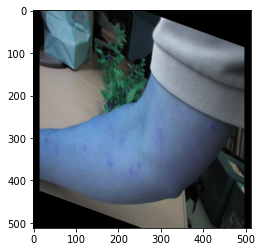

In [34]:
import matplotlib.pyplot as plt

plt.imshow(X_train_aug[20*20])